<a href="https://colab.research.google.com/github/jyojith/baeko/blob/main/training_demand_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Ensure GPU is enabled for faster computation
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


**FIRST APPROACH: LSTM(Long Short-Term Memory) RNN(Recurrent Neural Network)**

Saving bakery_pos_data (2).csv to bakery_pos_data (2) (5).csv


182/182 [==============================] - 2s 10ms/step
Train Score for Croissant: 2.16 RMSE
Test Score for Croissant: 2.13 RMSE


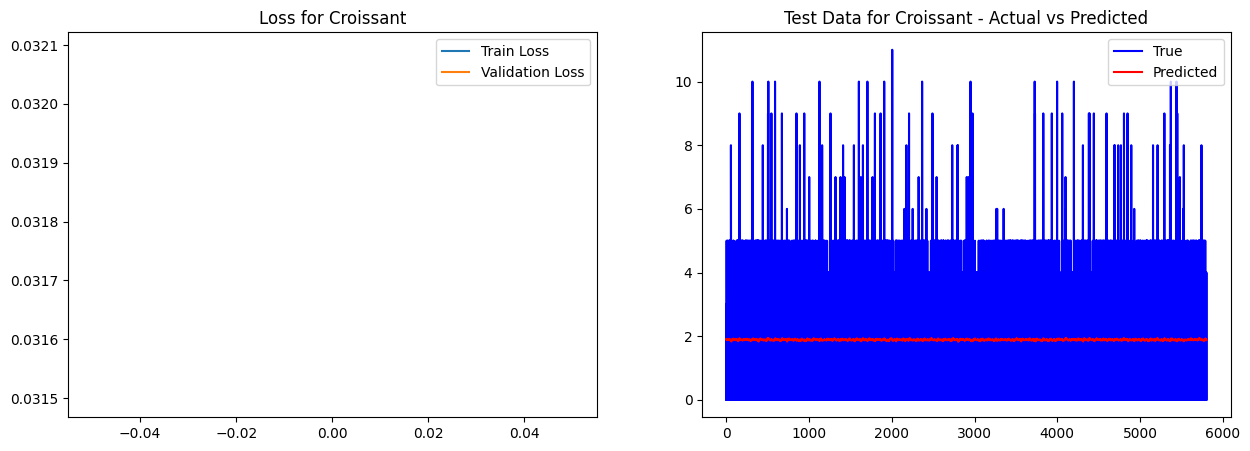

181/424 [===========>..................] - ETA: 31s - loss: 0.0204

KeyboardInterrupt: ignored

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt

# Load data
uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded.keys())))

# Convert TransactionDate to datetime type and sort
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df.sort_values(by='TransactionDate', inplace=True)

# Determine season based on the TransactionDate
def get_season(date):
    month = date.month
    day = date.day
    if month in [1, 2] or (month == 12 and day >= 21) or (month == 3 and day <= 20):
        return 'Winter'
    elif month in [4, 5] or (month == 3 and day >= 21) or (month == 6 and day <= 20):
        return 'Spring'
    elif month in [7, 8] or (month == 6 and day >= 21) or (month == 9 and day <= 20):
        return 'Summer'
    else:
        return 'Autumn'

df['Season'] = df['TransactionDate'].apply(get_season)
season_dummies = pd.get_dummies(df['Season'], prefix='Season')
df = pd.concat([df, season_dummies], axis=1)

# Pivot table to include the one-hot encoded season columns
df_pivot = df.pivot_table(index='TransactionDate', columns='ProductName', values=['Quantity', 'Season_Winter', 'Season_Spring', 'Season_Summer', 'Season_Autumn'], aggfunc=np.sum).fillna(0)

# Define the list of products
product_names = ["Croissant", "Chocolate Cake", "Blueberry Muffin", ...]  # truncated for brevity

# Define look-back
look_back = 14

# Define the function to create dataset with look-back
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        dataX.append(dataset[i:i + look_back, :])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# For each product, train a model, forecast, and visualize
for product_name in product_names:

    # Extract product specific data and season dummies
    df_product = df_pivot[[('Quantity', product_name), ('Season_Winter', product_name),
                           ('Season_Spring', product_name), ('Season_Summer', product_name),
                           ('Season_Autumn', product_name)]].reset_index(drop=True)

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_normalized = scaler.fit_transform(df_product)
    dataX, dataY = create_dataset(data_normalized, look_back)
    trainX, testX, trainY, testY = train_test_split(dataX, dataY, test_size=0.3, random_state=42, shuffle=False)

    # LSTM Model
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(look_back, 5), dropout=0.1, recurrent_dropout=0.1),
        tf.keras.layers.LSTM(50, dropout=0.1, recurrent_dropout=0.1),
        tf.keras.layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=1, batch_size=32, verbose=1, callbacks=[early_stop])

    # Predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # Invert predictions back to original scale
    trainPredict = scaler.inverse_transform(np.hstack((trainPredict, np.zeros((trainPredict.shape[0], 4)))))
    trainY_orig = scaler.inverse_transform(np.hstack((trainY.reshape(-1, 1), np.zeros((trainY.shape[0], 4)))))

    testPredict = scaler.inverse_transform(np.hstack((testPredict, np.zeros((testPredict.shape[0], 4)))))
    testY_orig = scaler.inverse_transform(np.hstack((testY.reshape(-1, 1), np.zeros((testY.shape[0], 4)))))

    # Calculate RMSE
    trainScore = math.sqrt(mean_squared_error(trainY_orig[:, 0], trainPredict[:, 0]))
    print(f"Train Score for {product_name}: {trainScore:.2f} RMSE")
    testScore = math.sqrt(mean_squared_error(testY_orig[:, 0], testPredict[:, 0]))
    print(f"Test Score for {product_name}: {testScore:.2f} RMSE")

    # Visualization: Losses and Actual vs Predicted
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss for {product_name}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(testY_orig[:, 0], label="True", color='blue')
    plt.plot(testPredict[:, 0], label="Predicted", color='red')
    plt.title(f"Test Data for {product_name} - Actual vs Predicted")
    plt.legend()
    plt.show()


**SECOND APPROACH: FACEBOOK MODEL**

In [ ]:
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
from google.colab import files

# 1. Load Data
uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded.keys())))

# Convert 'TransactionDate' to datetime format
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

# List of products for forecasting
product_names = [
    "Croissant", "Chocolate Cake", "Blueberry Muffin", "Roggenmischbrot", "Weißbrot",
    "Dinkelbrötchen", "Baguette", "Brezel", "Apple Strudel", "Cinnamon Roll",
    "Sourdough Bread", "Cherry Danish", "Eclair", "Pretzel", "Bagel",
    "Fruit Tart", "Almond Croissant", "Pumpernickel Bread", "Strawberry Shortcake",
    "Pain au Chocolat"
]

# Set a consistent style for presentation plots
plt.style.use('ggplot')

# Forecasting for each product
for product_name in product_names:

    # Preparing dataframe for Prophet
    df_product = df[df['ProductName'] == product_name]
    df_prophet = df_product.groupby('TransactionDate').sum().reset_index()
    df_prophet = df_prophet.rename(columns={'TransactionDate': 'ds', 'Quantity': 'y'})

    # Define and fit the model
    model = Prophet(yearly_seasonality=True, daily_seasonality=True)
    model.fit(df_prophet)

    # Making future dataframe for predictions (let's predict next 30 days)
    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)

    # Visualization for Presentation

    # Combined Plot
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

    # Actual vs Predicted plot
    ax[0].plot_date(df_prophet['ds'], df_prophet['y'], '-',
                    label='Actual Demand', color='blue')
    ax[0].plot_date(forecast['ds'], forecast['yhat'], '-',
                    label='Forecasted Demand', color='red')
    ax[0].set_title(f'Demand Forecasting for {product_name}')
    ax[0].set_xlabel('Date')
    ax[0].set_ylabel('Demand Quantity')
    ax[0].legend()

    # Trend and Yearly seasonality
    ax[1].plot_date(forecast['ds'], forecast['trend'], '-',
                    label='Trend', color='green')
    ax[1].plot_date(forecast['ds'], forecast['yearly'], '-',
                    label='Yearly Seasonality', color='purple')
    ax[1].set_title('Trend and Seasonality Components')
    ax[1].set_xlabel('Date')
    ax[1].set_ylabel('Demand Quantity')
    ax[1].legend()

    plt.tight_layout()
    plt.show()


ModuleNotFoundError: ignored